In [2]:
import numpy as np
import nibabel as nib
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt
from IPython import display
from pathlib import Path



fourdeeseg = '/data_rechenknecht03_2/students/kannath/ACDC/ACDC-Segmentation/fourdee_segmentations'
fourdeesegsplit = '/data_rechenknecht03_2/students/kannath/ACDC/ACDC-Segmentation/split_fourdee_segmentations'
fourdeeimagesplit = '/data_rechenknecht03_2/students/kannath/ACDC/ACDC-Segmentation/split_fourdee_images'
traingdata = '/data_rechenknecht03_2/students/kannath/ACDC/ACDC-Segmentation/training'

segsplit = Path(fourdeesegsplit)
imgsplit = Path(fourdeeimagesplit)
imgsplitfiles = sorted(list(imgsplit.rglob('*gz')))

segpatientfiles = sorted(list(segsplit.rglob('*gz')))
segpatient_split_path = []
imgpatient_split_path =[]
for patient in segpatientfiles:
    segpatient_split_path.append(str(patient))
for patient in imgsplitfiles:
    imgpatient_split_path.append(str(patient))
    


labels = {'Right_Ventricle': 5,
          'Left_Ventricle': 3,
          'Myocardium': 1}

# Functions and their definitions
1. __nii2tensor__ : To load and convert nii image object to tensor object    
1. __rotation_matrix__: otputs a 2x2 z-axis rotation matrix  with an angle theta deg
1. __affine_transform__: used to rotate a point with rotation_matrix 
1. __get_sparse_indices__: to convert input segmentation to a sparse tensor to find locations of the pixels of the segment of interest
1. __affine_matrix__: for creating an affine matrix with rotation and translation component
1. __spatialtransformer__: spatial transformation using grid sample  mapping the pixels from input cartesian plane to the output space ([0:H], [0:W]) -> ([-1,1], [-1,1]) (x, y) in input space corresponds to ((-1 + 2/H * x), (-1 + 2/W *y)) in output space

In [3]:
def nii2tensor(nii_data_path:str) -> torch.Tensor:
    nii2_tensor = torch.as_tensor(nib.load(nii_data_path).get_fdata())
   #if input nii2image (W, H, D, T) -> tensor (T, D, H, W), where T= time frame
    if nii2_tensor.dim() == 4:
        return nii2_tensor.permute(3, 2, 0, 1)
   #if input nii2image (W, H, T) -> tensor (T, H, W) or nii2image (W, H, D) -> tensor (D, H, W)
    elif nii2_tensor.dim() == 3:
        return nii2_tensor.permute(2, 0, 1)


def rotation_matrix(theta = 60) -> torch.Tensor(size=(2,2)):
    theta_rad = np.radians(theta)
    s = np.sin(theta_rad)
    c = np.cos(theta_rad)
    R = np.array(((c,-s), 
                  (s,c)))
    R_tensor = torch.as_tensor(R).float()
    
    return R_tensor


def affine_transform(point: torch.Tensor):
    return torch.matmul(rotation_matrix(), point.t()).t().float()
    

def get_sparse_indices(seg_tensor:torch.Tensor, label) -> torch.Tensor:
    segment = (seg_tensor == label)
    indices = segment.to_sparse().indices()
    return indices


def affine_matrix(rotation:torch.Tensor, translation:torch.Tensor):
    return torch.cat((rotation, translation),dim =1)


def spatialtransformer(input: torch.Tensor, affine_matrix: torch.Tensor):
    grid = F.affine_grid(affine_matrix, input.shape)
    return F.grid_sample(input, grid, align_corners = False)

In [4]:
class SegSpace2D():
    '''
    This class is to extract required coordinates of pixels in 2D segmented space -> (x, y) coordinate system
    '''
    def __init__(self, nii_tensor:torch.Tensor):
        self.nii_tensor = nii_tensor
    
    def get_origin(self,label) -> torch.Tensor:
        if label == labels['Right_Ventricle'] or label == labels['Left_Ventricle']:
            origin = get_sparse_indices(self.nii_tensor, label).float().mean(1)
        elif label == labels['Myocardium']:
            indices_myo = get_sparse_indices(self.nii_tensor, label).float()
            _ , n = indices_myo.shape
            # _, w = self.nii_tensor.shape
            origin = indices_myo[:,3*n//4]#took a random point located around the middle of myo seg as origin since taking the mean over all point outputs a point near to LV. (since they are similar to concentric circles)
            
        return torch.round(origin)
    
    def get_r_vectors(self, n, label_from, label_to)-> torch.Tensor: #outputs n+1 vectors from the centre of lv to myo
        vectors = []
        point_from = self.get_origin(label_from)
        point_to = self.get_origin(label_to)
        initial_point = point_to - point_from
        #initial_point_origin = 
        #vectors.append(initial_point)
        initial_vector_i = point_from + initial_point
        vectors.append(initial_vector_i)
        i = 0
        while i < n:
            rotated = affine_transform(initial_point)
            rotated_seg_origin_nxt = point_from + rotated
            vectors.append(rotated_seg_origin_nxt)
            initial_point = rotated
            i += 1
        
        return vectors

In [1]:
'''
if __name__ == '__main__':
   seg_image_n = nii2tensor(segpatient_split_path[2])[7]#segmented slice at frame 8
   seg = SegSpace2D(seg_image_n)
   #origin_myo = seg.get_origin(labels['Myocardium']) 
   #Rotation = [[1, 0],
   #            [0, 1]]
   rotated_vectors = seg.get_r_vectors(5, labels['Left_Ventricle'], label_to=labels['Myocardium'])
   extracted = []
   H, W = seg_image_n.shape
   for index in rotated_vectors:
       h, w = index
       h_grid_unit, w_grid_unit = (2/H)*h, (2/W)*w
       m, n = -1 + h_grid_unit , -1 + w_grid_unit
       translation =torch.as_tensor([m, n]).reshape(2,1)
       T = affine_matrix(torch.as_tensor(rotation_matrix(0)), translation).unsqueeze(0).float()
       seg_T = spatialtransformer(seg_image_n.unsqueeze(0).unsqueeze(0).float(), T)
       translation_ = torch.as_tensor([0, 0]).reshape(2,1)
       T_ = affine_matrix(torch.as_tensor(rotation_matrix(60)), translation_ ).unsqueeze(0).float()
       seg_T_rotated = spatialtransformer(seg_T, T_).squeeze(0).squeeze(0)
       points = seg_T_rotated[:,0]
       extracted.append(points)
'''

"\nif __name__ == '__main__':\n   seg_image_n = nii2tensor(segpatient_split_path[2])[7]#segmented slice at frame 8\n   seg = SegSpace2D(seg_image_n)\n   #origin_myo = seg.get_origin(labels['Myocardium']) \n   #Rotation = [[1, 0],\n   #            [0, 1]]\n   rotated_vectors = seg.get_r_vectors(5, labels['Left_Ventricle'], label_to=labels['Myocardium'])\n   extracted = []\n   H, W = seg_image_n.shape\n   for index in rotated_vectors:\n       h, w = index\n       h_grid_unit, w_grid_unit = (2/H)*h, (2/W)*w\n       m, n = -1 + h_grid_unit , -1 + w_grid_unit\n       translation =torch.as_tensor([m, n]).reshape(2,1)\n       T = affine_matrix(torch.as_tensor(rotation_matrix(0)), translation).unsqueeze(0).float()\n       seg_T = spatialtransformer(seg_image_n.unsqueeze(0).unsqueeze(0).float(), T)\n       translation_ = torch.as_tensor([0, 0]).reshape(2,1)\n       T_ = affine_matrix(torch.as_tensor(rotation_matrix(60)), translation_ ).unsqueeze(0).float()\n       seg_T_rotated = spatialtransfo

### Extracting points and Visualization

To visualize the transformations of segmentation input to the centre points

/home/kannath/.local/lib/python3.8/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


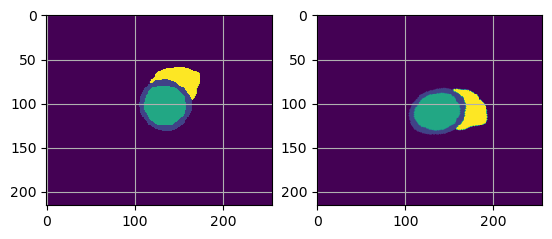

In [6]:
seg_image_n = nii2tensor(segpatient_split_path[3])[3]#segmented slice at frame 3
   # seg = SegSpace2D(seg_image_n)
   # rotated_vectors = seg.get_r_vectors(n=5, label_from = labels['Left_Ventricle'], label_to = labels['Myocardium'])
Rotation = rotation_matrix(0)
r = torch.as_tensor(Rotation)
r_ = torch.as_tensor(rotation_matrix(60))
seg = SegSpace2D(seg_image_n)
Y_l , X_l = seg.get_origin(labels['Left_Ventricle']).numpy() #rotated_vectors[5].numpy()
H, W = seg_image_n.shape
h_grid_unit, w_grid_unit = 2/H, 2/W
t = torch.as_tensor([(-1 + Y_l * h_grid_unit), (-1 + X_l * w_grid_unit)]).reshape(2,1)
t_ = torch.as_tensor([0, 0]).reshape(2,1)
seg_image_n = seg_image_n.unsqueeze(0).unsqueeze(0).float()
affine_grid = affine_matrix(r, t).unsqueeze(0).float()
affine_grid_ = affine_matrix(r_, t_).unsqueeze(0).float()
grid_sample = spatialtransformer(seg_image_n, affine_grid)
Y_m_i, X_m_i = seg.get_origin(labels['Myocardium']).numpy()
max_y, max_x = int(np.max([Y_l, Y_m_i])), int(np.max([X_l,X_m_i]))
min_y, min_x = int(np.min([Y_l, Y_m_i])), int(np.min([X_l,X_m_i]))
point_i = grid_sample.squeeze(0).squeeze(0)[min_y:max_y, int(X_l)]

points_extracted = []
grid_i = grid_sample


i = 1
while i < 6:
   rotate = rotation_matrix(i * 60)
   affine_grid_ = affine_matrix(rotate, t_).unsqueeze(0).float()
   grid_sample_temp = spatialtransformer(grid_i, affine_grid_)
   grid = SegSpace2D(grid_sample_temp.squeeze(0).squeeze(0))
   #Y_l_g , X_l_g = grid.get_origin(labels['Left_Ventricle']).numpy()
   Y_m_g, X_m_g =  grid.get_origin(labels['Myocardium']).numpy()
   max_y, max_x = int(np.max([Y_l, Y_m_g])), int(np.max([X_l,X_m_g]))
   min_y, min_x = int(np.min([Y_l, Y_m_g])), int(np.min([X_l,X_m_g]))
   point_i = grid_sample.squeeze(0).squeeze(0)[min_y:max_y, int(X_l)].int()
   points_extracted.append(point_i)
   grid_i = grid_sample_temp
   i+=1
   
grid_sample_ = spatialtransformer(grid_sample, affine_grid_)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.grid()
ax1.imshow(grid_sample.squeeze(0).squeeze(0).numpy())
ax2.grid()
ax2.imshow(grid_sample_.squeeze(0).squeeze(0).numpy())

